In [1]:
import numpy as np
import rioxarray as rxr
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
# Defining the AOH-extinction risk curve
def aoh_extinction_curve(aoh_hum_abs, aoh_new, curve_type = 'power_law', z = 0.25, a = 2.5, b = -14.5, 
                         alpha = 1, np_careful = False):
    assert curve_type in ['power_law', 'gompertz'], f'Curve type "{curve_type}" not supported'

    #  everything here v carefully uses Float64 for operations, to avoid errors w/small numbers
    if curve_type == 'power_law':
        if np_careful:
            prob_extinction = np.subtract(np.float64(1), np.float_power(np.divide(aoh_new, aoh_hum_abs), z))
        else:
            prob_extinction = 1 - ((aoh_new / aoh_hum_abs) ** z)
    elif curve_type == 'gompertz':
        if np_careful:
            prob_extinction = np.subtract(np.float64(1), np.exp(np.multiply(np.float64(-1), np.exp(np.add(np.float64(a), np.multiply(np.float64(b), np.float_power(np.divide(aoh_new, aoh_hum_abs), alpha)))))))
        else:
            prob_extinction = 1 - (np.exp(-1 * np.exp(a + b * ((aoh_new / aoh_hum_abs) ** alpha))))

    #  clip values to 0-1 range so they're probabilities
    prob_extinction = np.clip(prob_extinction, a_min = 0, a_max = 1)

    return prob_extinction

In [3]:
# Using forest elephant as an example species here
#   reading in the four needed rasters: (1) human-absent AOH, (2) current AOH, (3 + 4) hunting pressure maps
human_absent_aoh = rxr.open_rasterio('/Users/emiliolr/Desktop/hunting_testing/aohs/pnv/181007989_RESIDENT.tif')
human_absent_hp = rxr.open_rasterio('/Users/emiliolr/Desktop/hunting_testing/human_absent/181007989_hunting_pred_rf-pca.tif')

current_aoh = rxr.open_rasterio('/Users/emiliolr/Desktop/hunting_testing/aohs/current/181007989_RESIDENT.tif')
current_hp = rxr.open_rasterio('/Users/emiliolr/Desktop/hunting_testing/current/181007989_hunting_pred_rf-pca.tif')

#  ensure hunting pressure maps align precisely w/respective AOHs
human_absent_hp = human_absent_hp.rio.reproject_match(human_absent_aoh)
current_hp = current_hp.rio.reproject_match(current_aoh)

#  putting RR=1 (no hunting effect) in AOH areas with no predictions for hunting maps
no_pred_mask = ((human_absent_aoh != 0) & (xr.ufuncs.isnan(human_absent_hp)))
human_absent_hp = human_absent_hp.where(~no_pred_mask, other = 1)

no_pred_mask = ((current_aoh != 0) & (xr.ufuncs.isnan(current_hp)))
current_hp = current_hp.where(~no_pred_mask, other = 1)

#  getting current & human-absent AOH w/density modified by hunting
current_aoh_w_hunting = current_aoh * current_hp
current_aoh_w_hunting = current_aoh_w_hunting.rio.reproject_match(human_absent_aoh)

human_absent_aoh_w_hunting = human_absent_aoh * human_absent_hp

In [4]:
# Cast everything to Float64 to ensure precision in operations
human_absent_aoh = human_absent_aoh.astype('float64')
current_aoh_w_hunting = current_aoh_w_hunting.astype('float64')

In [5]:
# Looking at the effect of jointly restoring + abating hunting pressure -
#  making sure that when we take the difference, comparisons are made everywhere (doesn't
#  happen if one layers has null values but not the other)
human_absent_aoh = human_absent_aoh.fillna(0)
current_aoh_w_hunting = current_aoh_w_hunting.fillna(0)

#  the delta AOH in each pixel
delta_aoh_tot = human_absent_aoh - current_aoh_w_hunting

#  the total AOH if you restore/abate in each pixel
cur_aoh_hunting_tot = current_aoh_w_hunting.sum()
scenario_aoh_tot = cur_aoh_hunting_tot + delta_aoh_tot

#  the total AOH in absence of humans
hum_abs_aoh_tot = human_absent_aoh.sum()

#  calculating the change in prob of extinction
p0 = aoh_extinction_curve(hum_abs_aoh_tot, cur_aoh_hunting_tot, np_careful = True)
p1 = aoh_extinction_curve(hum_abs_aoh_tot, scenario_aoh_tot, np_careful = True)

delta_prob_ext_both = p1 - p0

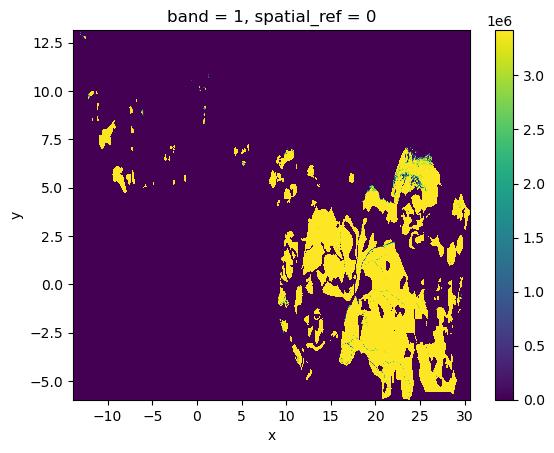

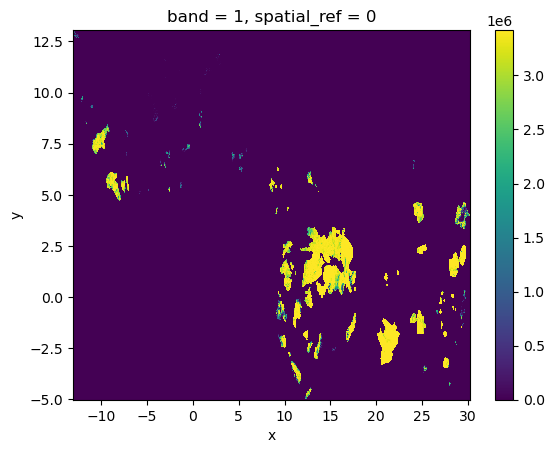

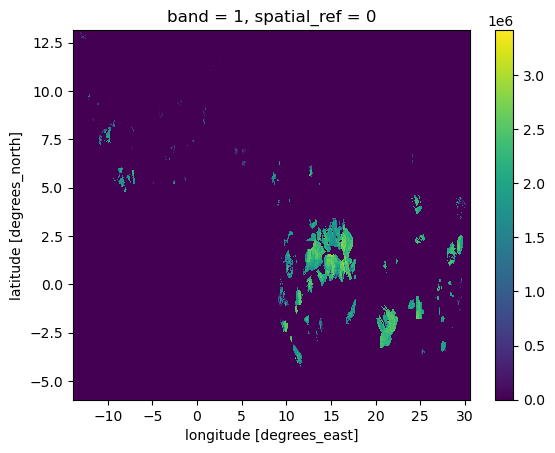

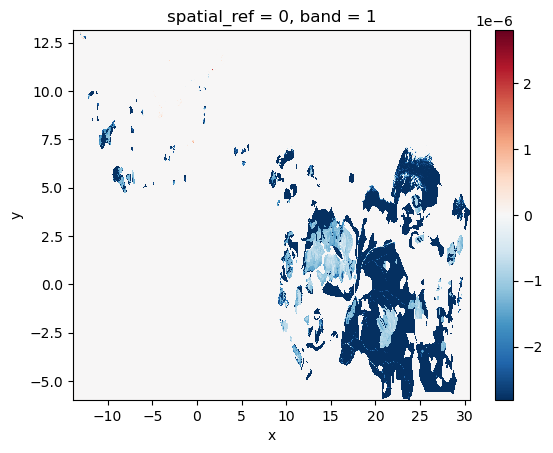

In [6]:
human_absent_aoh.plot()
plt.show()

current_aoh.plot()
plt.show()

current_aoh_w_hunting.plot()
plt.show()

delta_prob_ext_both.plot()
plt.show()

In [28]:
# Looking at the effect of just restoring PNV in the cell, but NOT abating hunting pressure
human_absent_aoh_w_hunting = human_absent_aoh_w_hunting.fillna(0)
current_aoh_w_hunting = current_aoh_w_hunting.fillna(0)

#  the delta AOH in each pixel
delta_aoh_restore = human_absent_aoh_w_hunting - current_aoh_w_hunting

#  the total AOH if you restore in each pixel
cur_aoh_hunting_tot = current_aoh_w_hunting.sum()
scenario_aoh_tot = cur_aoh_hunting_tot + delta_aoh_restore

#  the total AOH in absence of humans
hum_abs_aoh_tot = human_absent_aoh.sum()

#  calculating the change in prob of extinction
p0 = aoh_extinction_curve(hum_abs_aoh_tot, cur_aoh_hunting_tot, np_careful = True)
p1 = aoh_extinction_curve(hum_abs_aoh_tot, scenario_aoh_tot, np_careful = True)

delta_prob_ext_restore = p1 - p0

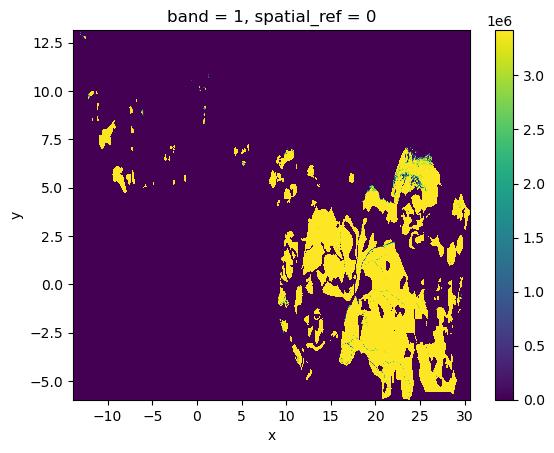

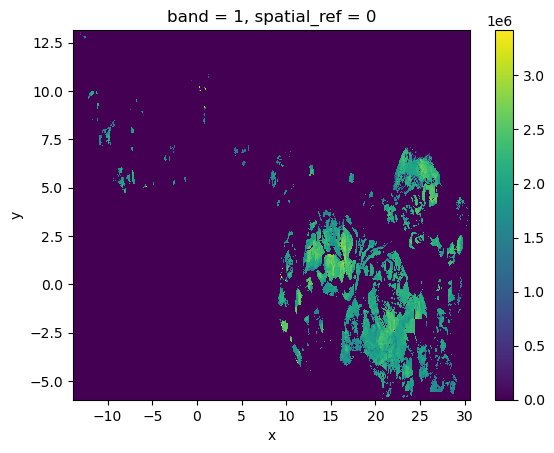

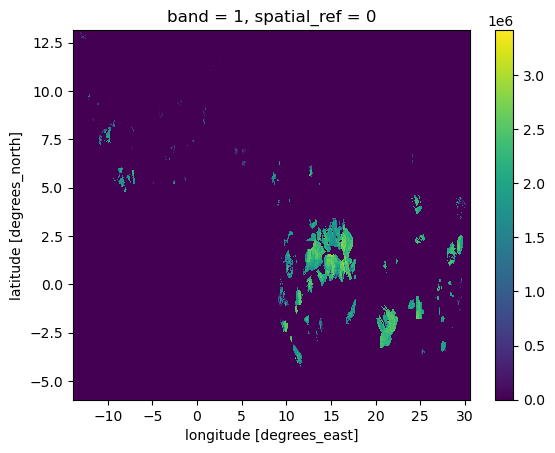

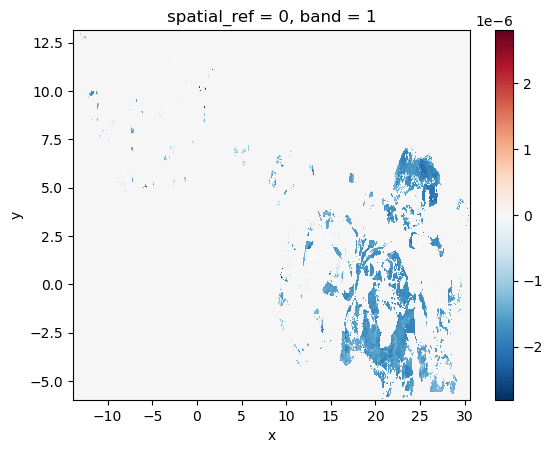

In [8]:
human_absent_aoh.plot()
plt.show()

human_absent_aoh_w_hunting.plot()
plt.show()

current_aoh_w_hunting.plot()
plt.show()

delta_prob_ext_restore.plot()
plt.show()

In [43]:
# Looking at the effect of just restoring PNV in the cell, in a world w/no hunting
current_aoh = current_aoh.rio.reproject_match(human_absent_aoh).fillna(0)

#  the delta AOH in each pixel
delta_aoh_restore_scenario = human_absent_aoh - current_aoh

#  the total AOH if you restore in each pixel
cur_aoh_tot = current_aoh.sum()
scenario_aoh_tot = cur_aoh_tot + delta_aoh_restore_scenario

#  the total AOH in absence of humans
hum_abs_aoh_tot = human_absent_aoh.sum()

#  calculating the change in prob of extinction
p0 = aoh_extinction_curve(hum_abs_aoh_tot, cur_aoh_tot, np_careful = True)
p1 = aoh_extinction_curve(hum_abs_aoh_tot, scenario_aoh_tot, np_careful = True)

delta_prob_ext_restore_scenario = p1 - p0

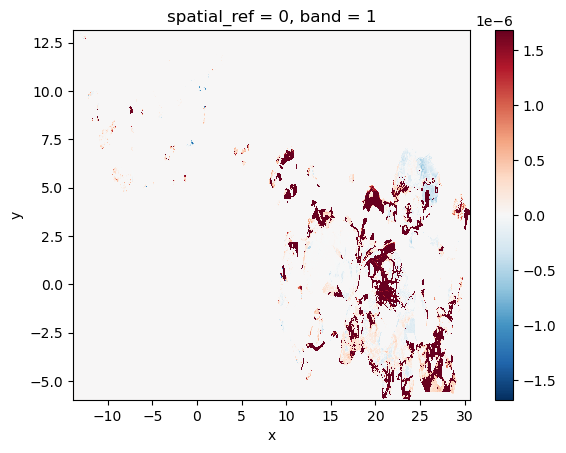

In [45]:
(delta_prob_ext_restore - delta_prob_ext_restore_scenario).plot()
plt.show()

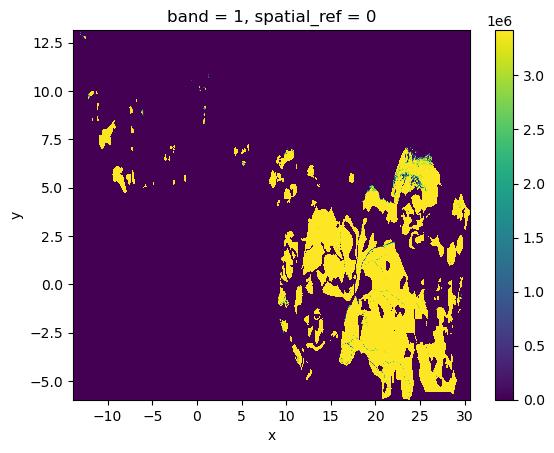

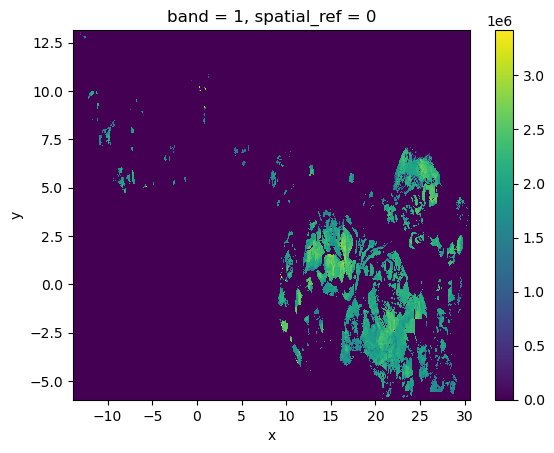

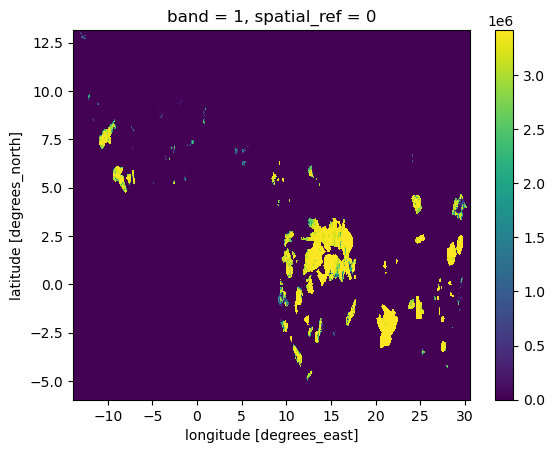

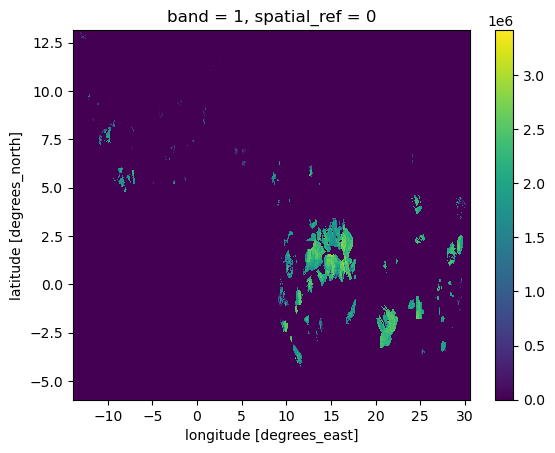

In [49]:
human_absent_aoh.plot()
plt.show()

human_absent_aoh_w_hunting.plot()
plt.show()

current_aoh.plot()
plt.show()

current_aoh_w_hunting.plot()
plt.show()